# Руководство по работе с библиотекой ChemX Client

**Добро пожаловать!**

Это руководство покажет, как легко и эффективно получать данные из научной платформы ChemX с помощью нашей Python-библиотеки.

**Основная идея:** вместо сложных HTTP-запросов вы используете простые Python-функции, которые возвращают данные сразу в `pandas.DataFrame`, готовом для анализа.

---

## 1. Установка и инициализация

Сначала установим все необходимые библиотеки и создадим экземпляр клиента.

In [1]:
# Устанавливаем библиотеку напрямую с GitHub
!pip install --upgrade git+https://github.com/ai-chem/chemx-client-python -q

# Устанавливаем библиотеки для анализа
!pip install pandas matplotlib seaborn -q

# Импортируем все необходимое
import pandas as pd
from chemx_client.client import ChemXClient, ChemXAPIError

# Настраиваем отображение таблиц
pd.set_option('display.max_columns', 50)

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Инициализируем клиент
client = ChemXClient()

## 2. Рекомендуемый способ получения данных (Универсальные методы)

Это самый гибкий и мощный способ работы с API. Он состоит из двух шагов:

### Шаг 1: Узнаем, какие данные доступны

Используем метод `get_schema()`, чтобы получить "карту" всех доступных наборов данных.

In [3]:
try:
    schema = client.get_schema()

    print("Доступные домены (domains)")
    print(schema['available_domains'])

    print("\nДоступные типы данных (data_types)")
    print(schema['available_data_types'])

except ChemXAPIError as e:
    print(f"Произошла ошибка: {e}")

Доступные домены (domains)
['cytotox', 'nanomag', 'nanozymes', 'seltox', 'synergy']

Доступные типы данных (data_types)
['all_data', 'ml_data', 'column_stats', 'row_stats', 'top_categories']


#### В чем разница между `data_type`?

*   `all_data`: **Полный набор данных.** Это широкая, денормализованная таблица, где собрана вся информация по домену. Идеально подходит для **исследовательского анализа (EDA)** и **визуализации**. В ней могут быть пропуски.

*   `ml_data`: **Данные, готовые для Машинного Обучения.** Это специальная версия `all_data`, в которой:
    *   **Заполнены пропуски и созданы индикаторы столбцыс подписью (*_imputed).**
    *   **Отобраны только полезные для ML признаки.** Служебные колонки и идентификаторы удалены.
    *   **Выполнена базовая предобработка данных**
    *   **Выбирайте этот тип**, если ваша цель — построить модель.

*   `column_stats`, `row_stats`, `top_categories`: **Готовая аналитика.** Это предрасчитанные сервером статистические сводки по данным. Используйте их, чтобы быстро оценить датасет, не скачивая его целиком.    
  
> ⚠️ **Важное замечание:**
> Наша предобработка **не является эталонной**. Основная цель `ml_data` — решить самые явные проблемы, такие как пропуски и разные единицы измерения, оставив данные максимально близкими к оригиналу.
>
> Такие шаги, как **энкодинг категориальных переменных**, **нормализация/стандартизация числовых признаков** или **генерация сложных дескрипторов**, остаются на усмотрение исследователя.

### Шаг 2: Загружаем нужный датасет
Теперь, зная все возможные `domain` и `data_type`, мы можем загрузить любой датасет с помощью универсального метода `get_dataset()`.

**Доступные параметры:**
*   `domain` (str): **Обязательный.** Имя домена из списка выше.
*   `data_type` (str): **Обязательный.** Тип данных из списка выше.
*   `nanoparticle` (str): *Необязательный.* Позволяет отфильтровать данные по названию наночастицы (работает только для `data_type='all_data'`).

#### Пример 1: Получение ML-данных по цитотоксичности

In [4]:
try:
    print("Загружаем ML-данные для домена 'cytotox'...")

    df_ml_cytotox = client.get_dataset(
        domain='cytotox',
        data_type='ml_data'
    )

    print(f"Успешно получено {len(df_ml_cytotox)} записей.")
    display(df_ml_cytotox.head())

except ChemXAPIError as e:
    print(f"Произошла ошибка: {e}")

Загружаем ML-данные для домена 'cytotox'...
Успешно получено 5476 записей.


,serial_number,nanoparticle,normalized_shape,has_coating,time_hr,cell_type,potential_mv,is_potential_mv_imputed,zeta_potential_mv,is_zeta_potential_mv_imputed,hydrodynamic_nm,is_hydrodynamic_nm_imputed,size_in_medium_nm,is_size_in_medium_nm_imputed,np_size_avg_nm,is_np_size_avg_nm_imputed,no_of_cells_cells_well,is_no_of_cells_cells_well_imputed,concentration,is_concentration_imputed,viability_percent,is_viability_percent_imputed,shape,is_shape_imputed,coat_functional_group,is_coat_functional_group_imputed,synthesis_method,is_synthesis_method_imputed,surface_charge,is_surface_charge_imputed,test,is_test_imputed,test_indicator,is_test_indicator_imputed,cell_source,is_cell_source_imputed,cell_tissue,is_cell_tissue_imputed,cell_morphology,is_cell_morphology_imputed,cell_age,is_cell_age_imputed,standardized_synthesis_method,is_standardized_synthesis_method_imputed,is_surface_positive,is_is_surface_positive_imputed,is_human,is_is_human_imputed
0,0,SiO2,spherical,1,12,PC12,-35.9,0,0.0,1,386.9,0,90.09,0,90.09,0,5000.0,0,1.95,0,113.670,0,Sphere,0,CTAB,0,Precipitation,0,Negative,0,MTT,0,TetrazoliumSalt,0,Rat,0,Unknown,1,Unknown,1,Unknown,1,Chemical Synthesis,0,False,0,False,0
1,1,SiO2,spherical,1,12,PC12,-35.9,0,0.0,1,386.9,0,90.09,0,90.09,0,5000.0,0,3.90,0,97.265,0,Sphere,0,CTAB,0,Precipitation,0,Negative,0,MTT,0,TetrazoliumSalt,0,Rat,0,Unknown,1,Unknown,1,Unknown,1,Chemical Synthesis,0,False,0,False,0
2,2,SiO2,spherical,1,12,PC12,-35.9,0,0.0,1,386.9,0,90.09,0,90.09,0,5000.0,0,7.80,0,108.730,0,Sphere,0,CTAB,0,Precipitation,0,Negative,0,MTT,0,TetrazoliumSalt,0,Rat,0,Unknown,1,Unknown,1,Unknown,1,Chemical Synthesis,0,False,0,False,0
3,3,SiO2,spherical,1,12,PC12,-35.9,0,0.0,1,386.9,0,90.09,0,90.09,0,5000.0,0,15.60,0,98.451,0,Sphere,0,CTAB,0,Precipitation,0,Negative,0,MTT,0,TetrazoliumSalt,0,Rat,0,Unknown,1,Unknown,1,Unknown,1,Chemical Synthesis,0,False,0,False,0
4,4,SiO2,spherical,1,12,PC12,-35.9,0,0.0,1,386.9,0,90.09,0,90.09,0,5000.0,0,31.20,0,98.056,0,Sphere,0,CTAB,0,Precipitation,0,Negative,0,MTT,0,TetrazoliumSalt,0,Rat,0,Unknown,1,Unknown,1,Unknown,1,Chemical Synthesis,0,False,0,False,0


#### Пример 2: Получение всех данных cytotox с фильтром

In [6]:
try:
    print("Загружаем все данные из домена 'cytotox', но только для наночастиц 'Fe3O4'...")

    df_filtered_cytotox = client.get_dataset(
        domain='cytotox',
        data_type='all_data',
        nanoparticle='Fe3O4'
    )

    print(f"Найдено {len(df_filtered_cytotox)} записей для 'Fe3O4'.")
    display(df_filtered_cytotox.head())

except ChemXAPIError as e:
    print(f"Произошла ошибка: {e}")

Загружаем все данные из домена 'cytotox', но только для наночастиц 'Fe3O4'...
Найдено 877 записей для 'Fe3O4'.


,serial_number,nanoparticle_id,nanoparticle,normalized_shape,shape,has_coating,np_size_avg_nm,canonical_name,coat_functional_group,standardized_synthesis_method,is_surface_positive,potential_mv,hydrodynamic_nm,zeta_potential_mv,size_in_medium_nm,surface_charge,synthesis_method,cell_line_id,canonical_cell_line_name,cell_type,human_animal,cell_source,cell_tissue,cell_morphology,cell_age,is_human,publication_id,doi,article_list,journal_name,publisher,year,title,journal_is_oa,is_oa,oa_status,pdf,access,access_bool,source_id,source_table,dbt_loaded_at,dbt_curated_at,no_of_cells_cells_well,time_hr,concentration,test,test_indicator,viability_percent
0,92,386,Fe3O4,spherical,Sphere,1,NaN,Fe3O4_spherical_1_NULL,Dextran,Green Synthesis,None,NaN,18.0,NaN,NaN,None,Thermal Decomposition,191,VERO_A_NULL_NULL_NULL_NULL_false,VERO,A,None,None,None,None,False,10,10.1002/jbm.b.33068,3,Journal of Biomedical Materials Research Part ...,Wiley,2014,<i>In vitro</i> and <i>in vivo</i> experiments...,False,True,green,3_mojicapisciotti2014.pdf,1,True,1,cytotox,1755259731704,1755259731704,10000.0,24,100.0,MTT,TetrazoliumSalt,102.00
1,93,386,Fe3O4,spherical,Sphere,1,NaN,Fe3O4_spherical_1_NULL,Dextran,Green Synthesis,None,NaN,18.0,NaN,NaN,None,Thermal Decomposition,191,VERO_A_NULL_NULL_NULL_NULL_false,VERO,A,None,None,None,None,False,10,10.1002/jbm.b.33068,3,Journal of Biomedical Materials Research Part ...,Wiley,2014,<i>In vitro</i> and <i>in vivo</i> experiments...,False,True,green,3_mojicapisciotti2014.pdf,1,True,1,cytotox,1755259731704,1755259731704,10000.0,24,200.0,MTT,TetrazoliumSalt,105.08
2,94,386,Fe3O4,spherical,Sphere,1,NaN,Fe3O4_spherical_1_NULL,Dextran,Green Synthesis,None,NaN,18.0,NaN,NaN,None,Thermal Decomposition,191,VERO_A_NULL_NULL_NULL_NULL_false,VERO,A,None,None,None,None,False,10,10.1002/jbm.b.33068,3,Journal of Biomedical Materials Research Part ...,Wiley,2014,<i>In vitro</i> and <i>in vivo</i> experiments...,False,True,green,3_mojicapisciotti2014.pdf,1,True,1,cytotox,1755259731704,1755259731704,10000.0,24,300.0,MTT,TetrazoliumSalt,100.00
3,95,386,Fe3O4,spherical,Sphere,1,NaN,Fe3O4_spherical_1_NULL,Dextran,Green Synthesis,None,NaN,18.0,NaN,NaN,None,Thermal Decomposition,191,VERO_A_NULL_NULL_NULL_NULL_false,VERO,A,None,None,None,None,False,10,10.1002/jbm.b.33068,3,Journal of Biomedical Materials Research Part ...,Wiley,2014,<i>In vitro</i> and <i>in vivo</i> experiments...,False,True,green,3_mojicapisciotti2014.pdf,1,True,1,cytotox,1755259731704,1755259731704,10000.0,24,400.0,MTT,TetrazoliumSalt,100.00
4,96,386,Fe3O4,spherical,Sphere,1,NaN,Fe3O4_spherical_1_NULL,Dextran,Green Synthesis,None,NaN,18.0,NaN,NaN,None,Thermal Decomposition,191,VERO_A_NULL_NULL_NULL_NULL_false,VERO,A,None,None,None,None,False,10,10.1002/jbm.b.33068,3,Journal of Biomedical Materials Research Part ...,Wiley,2014,<i>In vitro</i> and <i>in vivo</i> experiments...,False,True,green,3_mojicapisciotti2014.pdf,1,True,1,cytotox,1755259731704,1755259731704,10000.0,24,500.0,MTT,TetrazoliumSalt,80.00


## 3. Альтернативный способ (Специфичные методы)

Для удобства и обратной совместимости в библиотеке сохранены старые, специфичные методы для каждого домена.

По сути, это просто **"короткие команды" (шорткаты)** для универсального метода `get_dataset()`.

### Пример

In [7]:
df = client.get_cytotox_ml_data()

# делает то же самое, что и:

df = client.get_dataset(domain='cytotox', data_type='ml_data')

## Практический пример анализа и визуализации

Загрузка данных для Nanozymes...


/tmp/ipython-input-1577718753.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_doi.values, y=top_doi.index, palette='mako')


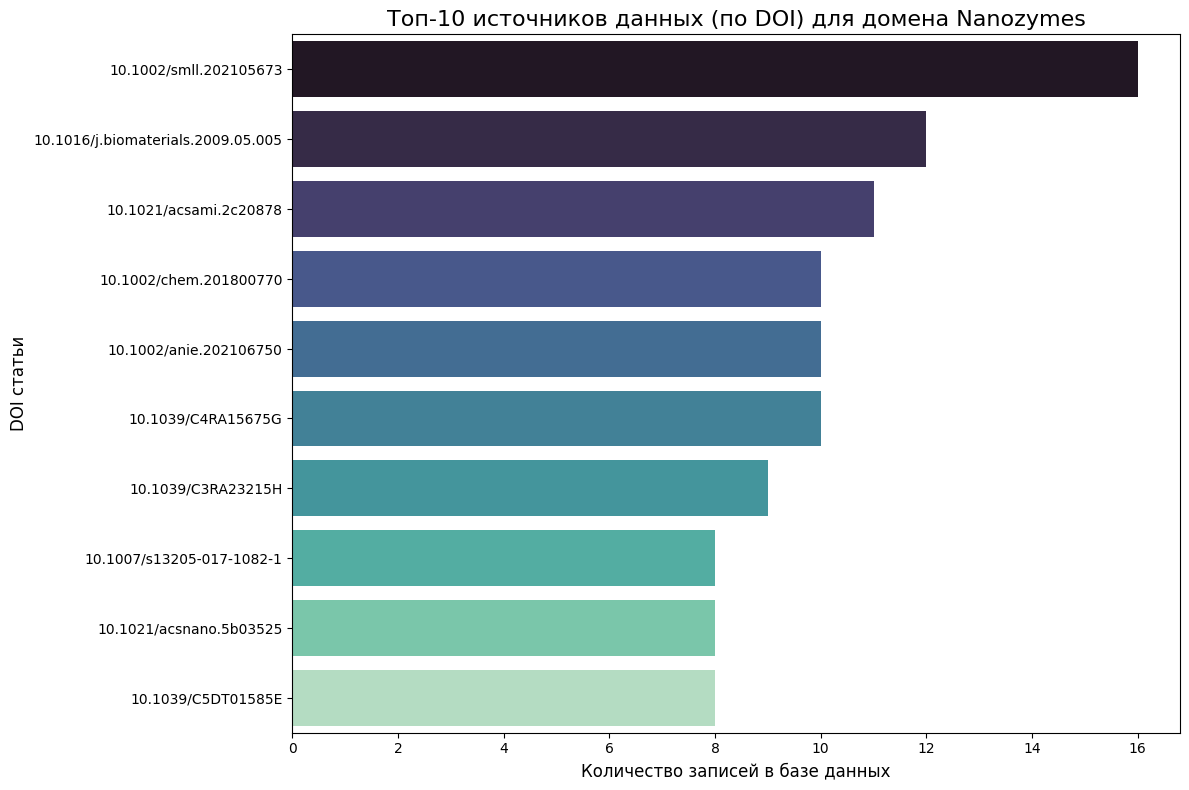

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

try:
    print("Загрузка данных для Nanozymes...")
    df_nanozymes = client.get_nanozymes_data()

    if not df_nanozymes.empty and 'doi' in df_nanozymes.columns:
        # Считаем количество записей для каждого DOI
        top_doi = df_nanozymes['doi'].value_counts().head(10)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=top_doi.values, y=top_doi.index, palette='mako', hue=top_doi.index, legend=False)

        plt.title('Топ-10 источников данных (по DOI) для домена Nanozymes', fontsize=16)
        plt.xlabel('Количество записей в базе данных', fontsize=12)
        plt.ylabel('DOI статьи', fontsize=12)
        plt.tight_layout()
        plt.show()
    else:
        print("Данные для анализа отсутствуют.")

except ChemXAPIError as e:
    print(f"Произошла ошибка: {e}")